In [2]:
import spacy
import re
import json
from collections import Counter, OrderedDict
import locale
from scipy.stats import rankdata
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import pearsonr, spearmanr, linregress, logistic
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from nltk.corpus import brown, gutenberg

nlp = spacy.load('en')
ps = nltk.stem.PorterStemmer()

In [63]:
# with open('data/walden.txt') as f:
#     text = f.readlines()
    
# text = re.sub(r'(\W[-—]|\n)', ' ', ''.join(text))
# docs = nlp(text)
# words = [ps.stem(tok.lemma_.lower()) for tok in docs if re.fullmatch(r'[A-Za-z\-\']+', tok.lemma_)]

In [3]:
glove_words = pickle.load(open('data/glove_words.pickle', 'rb'))

In [4]:
words = [word.lower() for word in gutenberg.words('austen-emma.txt') if word.lower() in glove_words]
len(words), len(set(words))

(187853, 7026)

In [6]:
word_levels = json.load(open('data/word-levels.json'), object_pairs_hook=OrderedDict)

In [77]:
%pprint
words[:100]

Pretty printing has been turned OFF


['[', 'emma', 'by', 'jane', 'austen', '1816', ']', 'volume', 'i', 'chapter', 'i', 'emma', 'woodhouse', ',', 'handsome', ',', 'clever', ',', 'and', 'rich', ',', 'with', 'a', 'comfortable', 'home', 'and', 'happy', 'disposition', ',', 'seemed', 'to', 'unite', 'some', 'of', 'the', 'best', 'blessings', 'of', 'existence', ';', 'and', 'had', 'lived', 'nearly', 'twenty', '-', 'one', 'years', 'in', 'the', 'world', 'with', 'very', 'little', 'to', 'distress', 'or', 'vex', 'her', '.', 'she', 'was', 'the', 'youngest', 'of', 'the', 'two', 'daughters', 'of', 'a', 'most', 'affectionate', ',', 'indulgent', 'father', ';', 'and', 'had', ',', 'in', 'consequence', 'of', 'her', 'sister', "'", 's', 'marriage', ',', 'been', 'mistress', 'of', 'his', 'house', 'from', 'a', 'very', 'early', 'period', '.', 'her']

In [7]:
set(word for word in words if word not in word_levels)

{'.', '_', '_______'}

In [8]:
words = [word for word in words if word in word_levels]

In [40]:
def simulate(ability, words, levels, mistake=0.001, guess=0.5):
    lookup = []
    seen = Counter()
    known = set()
    lookedup = set()
    for word in words:
        if word not in levels:
            continue
        if random.random() < mistake:
            lookup.append(word)
        else:
            if word not in seen:
                p = 1/(1 + np.exp(levels[word]-ability))
                if random.random() < p:
                    known.add(word)
            if word not in known and word not in lookedup:
                if random.random() >= np.power(guess, seen[word]+1):
                    lookup.append(word)
                    lookedup.add(word)
        seen[word] += 1
    return lookup

In [32]:
def avg_level(words_levels, lookup):
    return np.nanmean(np.vectorize(word_levels.get)(lookup))

In [73]:
def sim(guess):
    abilities = np.repeat(np.arange(13),100)
    lookups = [simulate(a, words, word_levels, mistake=0.001, guess=guess) for a in abilities]

    avg_levels =np.array([avg_level(word_levels, l) for l in lookups])
    print(pearsonr(abilities, avg_levels))

    plt.boxplot(avg_levels.reshape(13, 100).T)
    plt.xlabel('ability')
    plt.ylabel('average level of looked up words')
    plt.title(guess)
    plt.show()

(-0.3314938894827788, 1.0270631345956059e-34)


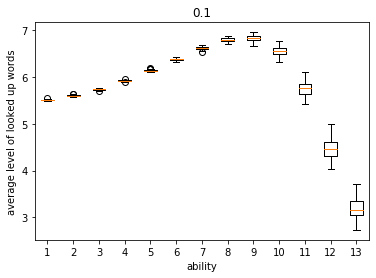

(-0.3588295635587714, 8.669024257821837e-41)


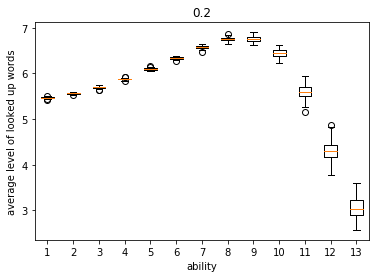

(-0.38104038076288577, 3.5082081621063556e-46)


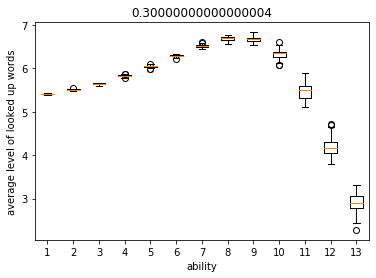

(-0.4076488332834418, 3.236094966319939e-53)


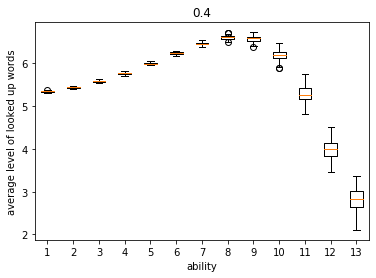

(-0.43264485098380806, 1.9654351992993992e-60)


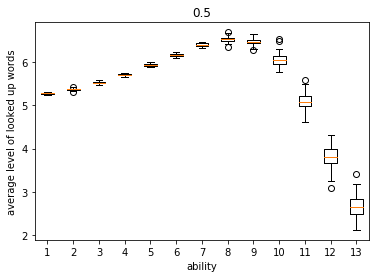

(-0.46808098490064715, 9.294242334396788e-72)


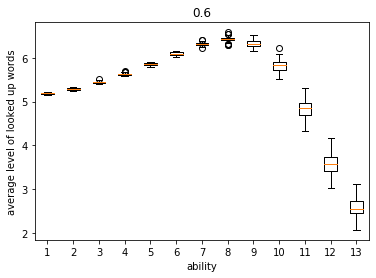

(-0.504157032647264, 9.622985145541682e-85)


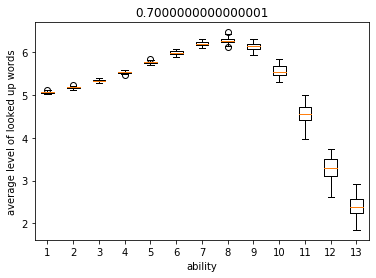

(-0.5540201902686447, 1.8275791961074236e-105)


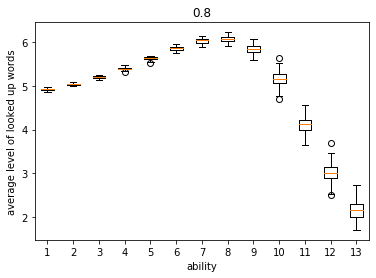

(-0.6229278055979512, 1.361267630869793e-140)


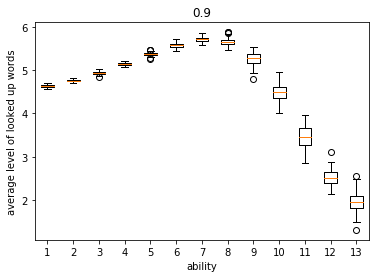

[None, None, None, None, None, None, None, None, None]

In [74]:
[sim(i) for i in np.arange(0.1, 1, 0.1)]

In [ ]:
user id, ability, know words

In [11]:
vocab = list(sorted(set(words)))
len(vocab)

7023

In [13]:
def simulate_users(size):
    abilities = np.repeat(np.arange(13), size)
    users = dict()
    for user_id, ability in enumerate(abilities):
        known = [random.random() < 1/(1 + np.exp(word_levels[word]-ability)) for word in vocab]
        users[user_id] = dict(ability=ability, known=known)
    return users

In [17]:
pickle.dump(dict(vocab=vocab, words=words), open('data/vocab.pickle', 'wb'))

In [20]:
pickle.dump(simulate_users(10), open('data/users-test.pickle', 'wb'))

In [18]:
pickle.dump(simulate_users(1), open('data/users-teeny.pickle', 'wb'))

In [109]:
pickle.dump(simulate_users(100), open('data/users-tiny.pickle', 'wb'))

In [14]:
pickle.dump(simulate_users(1000), open('data/users.pickle', 'wb'))

In [9]:
def simulate_lookups(users, words, mistake=0.001, guess=0.5):
    lookups = dict()
    for user_id, data in users.items():
        vocab_knowledge = dict(zip(vocab, data['known']))
        lookups[user_id]=dict(lookup=[], seen=[])
        seen = Counter()
        looked = Counter()
        for word in words:
            seen[word]+=1
            if random.random() < mistake:
                looked[word]+=1
            elif not vocab_knowledge[word]:
                if random.random() >= np.power(guess, seen[word]/(np.power(2, looked[word]))):
                    looked[word]+=1
            lookups[user_id]['lookup'].append(looked[word])
            lookups[user_id]['seen'].append(seen[word])
    return lookups

In [ ]:
simulate_lookups(simulate_users(1), words)

In [19]:
pickle.dump(simulate_lookups(pickle.load(open('data/users-teeny.pickle', 'rb')), words), open('data/lookups-teeny.pickle', 'wb'))

In [ ]:
pickle.dump(simulate_lookups(pickle.load(open('data/users-tiny.pickle', 'rb')), words), open('data/lookups-tiny.pickle', 'wb'))

In [15]:
pickle.dump(simulate_lookups(pickle.load(open('data/users.pickle', 'rb')), words), open('data/lookups.pickle', 'wb'))

In [21]:
pickle.dump(simulate_lookups(pickle.load(open('data/users-test.pickle', 'rb')), words), open('data/lookups-test.pickle', 'wb'))